> __Purpose:__ Implement an initial privacy attack to quantify how much re-identiifcation and linkability risk exists from  filtered EMG data (should be highly unique). Thus, implement a basic ML model to link the EMG data back to the corresponding subject.  

1. Make EMG Envelope: moving average OR RMS -- 100 ms windows, no overlap -- end up with ~200 samples for the 20 second window at the beginning and end
2. PCA on the channels - decrease # of channels, run PCA on all participants to find X significant axes (somewhere between 3-6), and then apply the same transformation to all participants
3. Then do ML

-- 7 Subjects, therefore pure guessing would be 14.28% correct on average

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn
import time
import pandas as pd
import pickle
import random
from kcs_ml_infr import *

random.seed(a=1)

# Load In Data

In [25]:
keys = ['METACPHS_S106', 'METACPHS_S107','METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112']

key_to_num = dict()
num_to_key = dict()
for idx, key in enumerate(keys):
    key_to_num[key] = idx
    num_to_key[idx] = key

update_ix = np.load(r"Data\update_ix.npy")
print(update_ix.shape)
print(update_ix)

(19,)
[    0  1200  2402  3604  4806  6008  7210  8412  9614 10816 12018 13220
 14422 15624 16826 18028 19230 20432 20769]


Load in the other data
> This cell takes forever to run...

In [3]:
t0 = time.time()

emg_data_df1 = pd.read_csv("Data\emg_data1.csv")
emg_labels_df1 = pd.read_csv("Data\emg_labels1.csv")
emg_data_df2 = pd.read_csv("Data\emg_data2.csv")
emg_labels_df2 = pd.read_csv("Data\emg_labels2.csv")

t1 = time.time()
total = t1-t0  
print(total)

1490.8569362163544


In [4]:
emg_data_df = pd.concat((emg_data_df1, emg_data_df2))
emg_labels_df = pd.concat((emg_labels_df1, emg_labels_df2))

In [5]:
print(emg_data_df.shape)
emg_data_df.drop('Unnamed: 0', axis=1, inplace=True)
emg_data_df.head()

(7232, 20771)


,0,1,2,3,4,5,6,7,8,9,...,20760,20761,20762,20763,20764,20765,20766,20767,20768,20769
0,0.0,0.0,0.0,10.778148,10.778148,10.778148,26.874088,43.189501,43.189501,38.594581,...,54.343173,54.343173,53.363208,53.363208,53.363208,53.363208,59.557374,59.557374,59.557374,55.634152
1,0.0,0.0,0.0,9.891218,9.891218,9.891218,23.589349,36.477933,36.477933,31.296507,...,79.894291,79.894291,86.860329,86.860329,86.860329,86.860329,71.319955,71.319955,71.319955,56.606641
2,0.0,0.0,0.0,1.606057,1.606057,1.606057,8.623857,15.845217,15.845217,17.957593,...,89.500295,89.500295,84.266738,84.266738,84.266738,84.266738,71.979639,71.979639,71.979639,65.918534
3,0.0,0.0,0.0,3.668527,3.668527,3.668527,7.165376,11.628290,11.628290,15.308951,...,68.943668,68.943668,66.983974,66.983974,66.983974,66.983974,64.104558,64.104558,64.104558,61.848159
4,0.0,0.0,0.0,1.411810,1.411810,1.411810,9.707134,15.677262,15.677262,18.922410,...,43.565918,43.565918,42.343590,42.343590,42.343590,42.343590,42.235306,42.235306,42.235306,41.818073


In [6]:
print(emg_labels_df.shape)
emg_labels_df.drop('Unnamed: 0', axis=1, inplace=True)
emg_labels_df.head()

(7232, 4)


,Subject,Condition,Channel
0,METACPHS_S106,0,0
1,METACPHS_S106,0,1
2,METACPHS_S106,0,2
3,METACPHS_S106,0,3
4,METACPHS_S106,0,4


In [26]:
labels_df = pd.DataFrame(emg_labels_df['Subject'].map(key_to_num))
labels_df.head()

,Subject
0,0
1,0
2,0
3,0
4,0


# Filtered EMG Data Privacy Evaluation
>Linking EMG Data to Participants
1. Does the channel matter / improve performance? Within the same block (assuming different blocks have the strap re-put on) then presumably the same muscles should act in similar ways.  __Just do PCA on it and don't worry about it__
2. Does the condition matter? Presumably, but the question is how much.  __Only look at condition for conditions that changed performance (eg learning rate speed)__
3. Ways to compress the input data: PCA/LDA/nonlinearversion, or norms of the vectors... is it even necessary / beneficial to performance.  __Focus on just PCA for now__
4. __No standard scaler since negative filtered EMG data has no meaning__

## 1) Create Envelope of Filtered EMG Data

In [16]:
assert(1==0)
# Don't run the below cell cause it takes forever, but keep the output

AssertionError: 

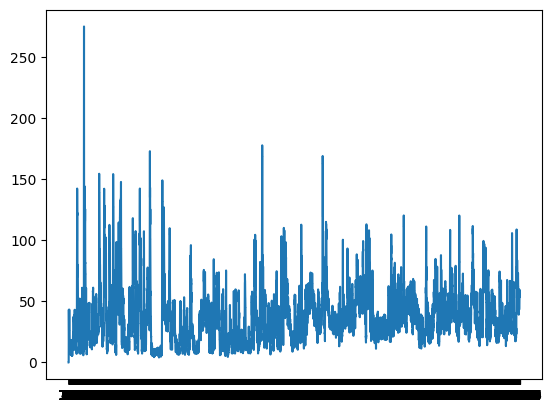

In [10]:
plt.plot(emg_data_df.iloc[0, :])
plt.show()

In [11]:
type(emg_data_df)

pandas.core.frame.DataFrame

Crude moving average with no overlap

In [7]:
envelope_df = emg_data_df.groupby(np.arange(len(emg_data_df.columns))//100, axis=1).mean()

print(envelope_df.shape)
envelope_df.head()

(7232, 208)


,0,1,2,3,4,5,6,7,8,9,...,198,199,200,201,202,203,204,205,206,207
0,14.129705,11.959808,28.685874,33.823858,42.311438,22.872970,28.686864,91.792338,26.813570,28.583164,...,43.676011,39.113891,27.947874,31.573392,36.614566,35.604320,51.523493,31.292127,59.277122,51.997711
1,13.895036,12.063848,22.026072,27.027048,59.187831,23.013614,30.960467,81.718608,29.116355,28.694447,...,41.396844,44.348191,31.188022,30.580405,32.773796,39.768986,51.494867,29.641406,47.146682,58.581918
2,13.214033,15.229451,23.956005,25.832507,48.218284,29.437285,27.001414,35.878805,29.420835,31.587059,...,27.507856,35.271588,28.060107,24.463167,30.750010,39.033112,31.714344,17.286340,30.174009,49.750919
3,13.979167,16.414878,19.550628,21.984005,32.083749,26.856702,23.001818,21.776800,23.041464,24.603026,...,21.163787,27.844200,26.265045,24.563413,29.984113,35.764448,23.072423,15.670036,22.936556,38.122263
4,10.168381,10.501039,12.856129,16.059131,20.128401,13.435236,16.672336,18.134148,20.744904,21.606347,...,14.751494,19.967234,19.091210,16.293000,20.945203,25.093296,14.147869,10.369884,15.788238,26.206604


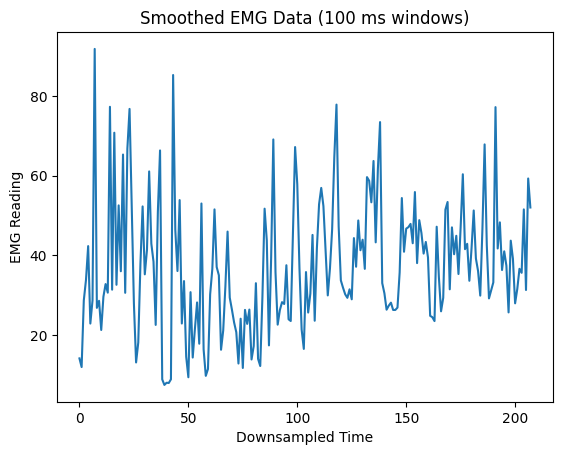

In [8]:
# This is substantially different than the original lol
plt.plot(envelope_df.iloc[0, :])
plt.xlabel("Downsampled Time")
plt.ylabel("EMG Reading")
plt.title("Smoothed EMG Data (100 ms windows)")
plt.show()

Using the rolling function

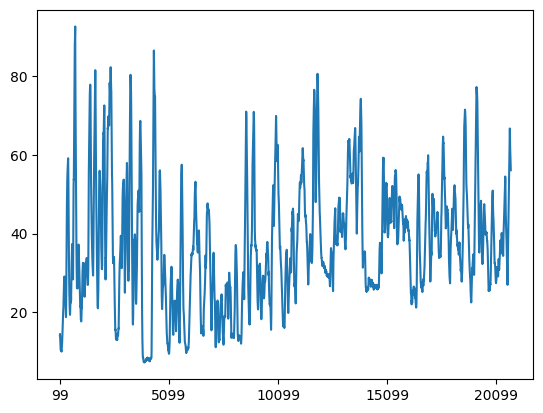

In [15]:
ex = emg_data_df.iloc[0, :].rolling(window=100).mean().dropna().plot()

## 2) PCA On the Channels
> https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis

In [16]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

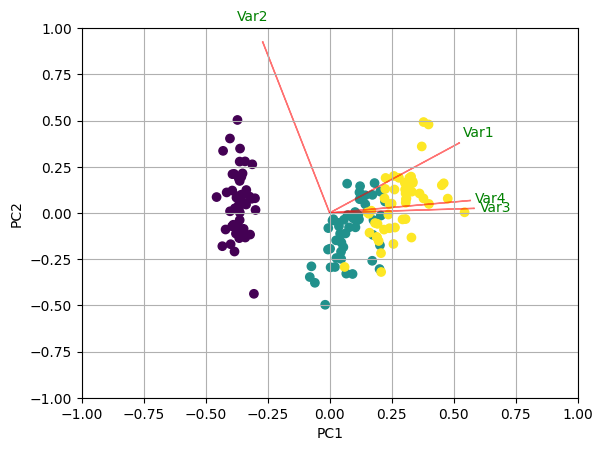

In [17]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
#In general a good idea is to scale the data
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    

pca = PCA()
x_new = pca.fit_transform(X)

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

In [18]:
pca.explained_variance_ratio_

array([0.72962445, 0.22850762, 0.03668922, 0.00517871])

In [19]:
print(abs( pca.components_ ))

[[0.52106591 0.26934744 0.5804131  0.56485654]
 [0.37741762 0.92329566 0.02449161 0.06694199]
 [0.71956635 0.24438178 0.14212637 0.63427274]
 [0.26128628 0.12350962 0.80144925 0.52359713]]


Here, pca.components_ has shape [n_components, n_features]. Thus, by looking at the PC1 (First Principal Component) which is the first row: [0.52237162 0.26335492 0.58125401 0.56561105]] we can conclude that feature 1, 3 and 4 (or Var 1, 3 and 4 in the biplot) are the most important. This is also clearly visible from the biplot (that's why we often use this plot to summarize the information in a visual way).

To sum up, look at the absolute values of the Eigenvectors' components corresponding to the k largest Eigenvalues. In sklearn the components are sorted by explained_variance_. The larger they are these absolute values, the more a specific feature contributes to that principal component.



In [20]:
# To get the most important features on the PCs with names and save them into a pandas dataframe use this:

from sklearn.decomposition import PCA
np.random.seed(0)

# 10 samples with 5 features
train_features = np.random.rand(10,5)

model = PCA(n_components=2).fit(train_features)
X_pc = model.transform(train_features)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = ['a','b','c','d','e']
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())

Now repeat but using my data

In [21]:
print(envelope_df.shape)
envelope_df.head()

(7232, 208)


,0,1,2,3,4,5,6,7,8,9,...,198,199,200,201,202,203,204,205,206,207
0,14.129705,11.959808,28.685874,33.823858,42.311438,22.872970,28.686864,91.792338,26.813570,28.583164,...,43.676011,39.113891,27.947874,31.573392,36.614566,35.604320,51.523493,31.292127,59.277122,51.997711
1,13.895036,12.063848,22.026072,27.027048,59.187831,23.013614,30.960467,81.718608,29.116355,28.694447,...,41.396844,44.348191,31.188022,30.580405,32.773796,39.768986,51.494867,29.641406,47.146682,58.581918
2,13.214033,15.229451,23.956005,25.832507,48.218284,29.437285,27.001414,35.878805,29.420835,31.587059,...,27.507856,35.271588,28.060107,24.463167,30.750010,39.033112,31.714344,17.286340,30.174009,49.750919
3,13.979167,16.414878,19.550628,21.984005,32.083749,26.856702,23.001818,21.776800,23.041464,24.603026,...,21.163787,27.844200,26.265045,24.563413,29.984113,35.764448,23.072423,15.670036,22.936556,38.122263
4,10.168381,10.501039,12.856129,16.059131,20.128401,13.435236,16.672336,18.134148,20.744904,21.606347,...,14.751494,19.967234,19.091210,16.293000,20.945203,25.093296,14.147869,10.369884,15.788238,26.206604


Let's restrict it to just the first condition of the first participant, so just the first 64 rows (64 channels)

In [75]:
first_subj_df = envelope_df.iloc[:64, :]

print(first_subj_df.shape)
first_subj_df.head()

(64, 208)


,0,1,2,3,4,5,6,7,8,9,...,198,199,200,201,202,203,204,205,206,207
0,14.129705,11.959808,28.685874,33.823858,42.311438,22.872970,28.686864,91.792338,26.813570,28.583164,...,43.676011,39.113891,27.947874,31.573392,36.614566,35.604320,51.523493,31.292127,59.277122,51.997711
1,13.895036,12.063848,22.026072,27.027048,59.187831,23.013614,30.960467,81.718608,29.116355,28.694447,...,41.396844,44.348191,31.188022,30.580405,32.773796,39.768986,51.494867,29.641406,47.146682,58.581918
2,13.214033,15.229451,23.956005,25.832507,48.218284,29.437285,27.001414,35.878805,29.420835,31.587059,...,27.507856,35.271588,28.060107,24.463167,30.750010,39.033112,31.714344,17.286340,30.174009,49.750919
3,13.979167,16.414878,19.550628,21.984005,32.083749,26.856702,23.001818,21.776800,23.041464,24.603026,...,21.163787,27.844200,26.265045,24.563413,29.984113,35.764448,23.072423,15.670036,22.936556,38.122263
4,10.168381,10.501039,12.856129,16.059131,20.128401,13.435236,16.672336,18.134148,20.744904,21.606347,...,14.751494,19.967234,19.091210,16.293000,20.945203,25.093296,14.147869,10.369884,15.788238,26.206604


Repeat process but for labels

In [76]:
print(emg_labels_df.shape)
emg_labels_df.head()

(7232, 3)


,Subject,Condition,Channel
0,METACPHS_S106,0,0
1,METACPHS_S106,0,1
2,METACPHS_S106,0,2
3,METACPHS_S106,0,3
4,METACPHS_S106,0,4


In [72]:
print(labels_df.shape)
labels_df.head()

(7232, 1)


,Subject
0,0
1,0
2,0
3,0
4,0


In [77]:
first_subj_labels_df = labels_df.iloc[:64, :]

print(first_subj_labels_df.shape)
first_subj_labels_df.head()

(64, 1)


,Subject
0,0
1,0
2,0
3,0
4,0


Now run actual PCA

In [103]:
X = first_subj_df
y = first_subj_labels_df

# Maybe don't do SS since negative EMG is weird
# Not using it just flips the figure, as far as I can tell
#scaler = StandardScaler()
#scaler.fit(X)
#X=scaler.transform(X)    

pca = PCA()
x_new = pca.fit_transform(X)

In [104]:
x_new.shape

(64, 64)

In [105]:
x_new[:,0:2].shape

(64, 2)

In [106]:
xs = x_new[:,0]
xs.shape

(64,)

In [107]:
ys = x_new[:,1]
ys.shape

(64,)

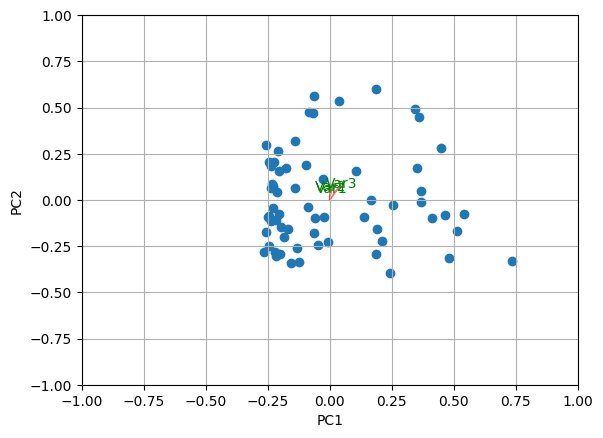

In [108]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    
    # This is the line with the error
    #plt.scatter(xs * scalex,ys * scaley, c = y)
    plt.scatter(xs * scalex,ys * scaley)#, c = y)
    
    # Changed this to reflect just the top 3 components
    for i in range(3):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

In [109]:
print(pca.explained_variance_ratio_.shape)

(64,)


In [110]:
pca.explained_variance_ratio_[0:20]

array([8.18949390e-01, 7.12233499e-02, 5.51405036e-02, 1.51749669e-02,
       1.01393608e-02, 5.88521964e-03, 5.08292819e-03, 4.05777564e-03,
       3.82422076e-03, 2.48049487e-03, 1.78775009e-03, 9.97103634e-04,
       7.15884972e-04, 5.88867560e-04, 4.72852397e-04, 4.33326590e-04,
       3.86697513e-04, 3.35551090e-04, 2.46200794e-04, 2.33478621e-04])

In [111]:
pca.explained_variance_ratio_.cumsum()[0:4]

array([0.81894939, 0.89017274, 0.94531324, 0.96048821])

In [93]:
pca.explained_variance_ratio_

array([8.18949390e-01, 7.12233499e-02, 5.51405036e-02, 1.51749669e-02,
       1.01393608e-02, 5.88521964e-03, 5.08292819e-03, 4.05777564e-03,
       3.82422076e-03, 2.48049487e-03, 1.78775009e-03, 9.97103634e-04,
       7.15884972e-04, 5.88867560e-04, 4.72852397e-04, 4.33326590e-04,
       3.86697513e-04, 3.35551090e-04, 2.46200794e-04, 2.33478621e-04,
       2.06245146e-04, 1.86655839e-04, 1.42828981e-04, 1.38166136e-04,
       1.25447520e-04, 1.18113339e-04, 1.11533028e-04, 1.08638862e-04,
       8.95237552e-05, 7.96869465e-05, 6.73600360e-05, 5.45193323e-05,
       4.82204581e-05, 4.02009986e-05, 3.81835533e-05, 3.33588619e-05,
       3.12441870e-05, 2.58675116e-05, 2.36252691e-05, 2.13855110e-05,
       1.87354680e-05, 1.69080258e-05, 1.52104597e-05, 1.27520227e-05,
       1.18848350e-05, 1.03464725e-05, 9.63391789e-06, 8.73079649e-06,
       7.37566826e-06, 6.23660517e-06, 5.87754592e-06, 4.88074941e-06,
       4.62923425e-06, 3.43757709e-06, 3.31193913e-06, 3.17849030e-06,
      

Use 4 channels to get 96% of variance

## Now try to figure out if rows actually mean anything
> Eg add a row of all 0s at the beginning of the df to see if this still captures information.  If pca.explained_variance_ratio_ is no longer "sorted" then it isnt sorted to begin with and thus I can just take the top rows

In [114]:
first_subj_df.shape

(64, 208)

In [115]:
TESTING_first_subj_df = first_subj_df.copy(deep=True)
TESTING_first_subj_df.loc[-1] = [0]*208  # adding a row
TESTING_first_subj_df.index = TESTING_first_subj_df.index + 1  # shifting index
TESTING_first_subj_df.sort_index(inplace=True) 

print(TESTING_first_subj_df.shape)
TESTING_first_subj_df.head()

(65, 208)


,0,1,2,3,4,5,6,7,8,9,...,198,199,200,201,202,203,204,205,206,207
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,14.129705,11.959808,28.685874,33.823858,42.311438,22.872970,28.686864,91.792338,26.813570,28.583164,...,43.676011,39.113891,27.947874,31.573392,36.614566,35.604320,51.523493,31.292127,59.277122,51.997711
2,13.895036,12.063848,22.026072,27.027048,59.187831,23.013614,30.960467,81.718608,29.116355,28.694447,...,41.396844,44.348191,31.188022,30.580405,32.773796,39.768986,51.494867,29.641406,47.146682,58.581918
3,13.214033,15.229451,23.956005,25.832507,48.218284,29.437285,27.001414,35.878805,29.420835,31.587059,...,27.507856,35.271588,28.060107,24.463167,30.750010,39.033112,31.714344,17.286340,30.174009,49.750919
4,13.979167,16.414878,19.550628,21.984005,32.083749,26.856702,23.001818,21.776800,23.041464,24.603026,...,21.163787,27.844200,26.265045,24.563413,29.984113,35.764448,23.072423,15.670036,22.936556,38.122263


In [116]:
TESTING_first_subj_labels_df = first_subj_labels_df.copy(deep=True)
TESTING_first_subj_labels_df.loc[-1] = [0]  # adding a row
TESTING_first_subj_labels_df.index = TESTING_first_subj_labels_df.index + 1  # shifting index
TESTING_first_subj_labels_df.sort_index(inplace=True) 

print(TESTING_first_subj_labels_df.shape)
TESTING_first_subj_labels_df.head()

(65, 1)


,Subject
0,0
1,0
2,0
3,0
4,0


In [117]:
X = TESTING_first_subj_df
y = TESTING_first_subj_labels_df

# Maybe don't do SS since negative EMG is weird
# Not using it just flips the figure, as far as I can tell
#scaler = StandardScaler()
#scaler.fit(X)
#X=scaler.transform(X)    

pca = PCA()
x_new = pca.fit_transform(X)

In [118]:
print(pca.explained_variance_ratio_.shape)

(65,)


In [119]:
pca.explained_variance_ratio_[0:20]

array([8.19114187e-01, 7.19051552e-02, 5.46854820e-02, 1.56556408e-02,
       9.97130300e-03, 5.78926780e-03, 4.94265919e-03, 3.94526512e-03,
       3.69755216e-03, 2.40379877e-03, 1.72999823e-03, 9.97110833e-04,
       6.95033011e-04, 5.74368479e-04, 4.68882369e-04, 4.23407091e-04,
       3.76150475e-04, 3.24580524e-04, 2.52943358e-04, 2.26771020e-04])

In [120]:
pca.explained_variance_ratio_.cumsum()[0:4]

array([0.81911419, 0.89101934, 0.94570482, 0.96136046])

I don't think this necessarily tells me what I wanted, it still concievable could be the case that the all zero row still captures a lot of variance maybe?

# Pipeline for Finding n_components
Choosing just 2 components was super arbitrary, ought to do some analysis

In [52]:
def do_pca(num_cs, input_df):
    pca=PCA(n_components=num_cs)
    pca.fit(input_df)
    x_pca=pca.transform(input_df)

    return x_pca

Could drop channel column, or combine subject and channel into 1 label. Dropping channel column is easiest but presumably loses some info (eg if channel is place over same muscle that could provide a better matching criterion, but this may be counteracted if the two blocks had sensors placed in different places

In [43]:
emg_labels_df.head()

,Subject,Condition,Channel
0,METACPHS_S106,0,0
1,METACPHS_S106,0,1
2,METACPHS_S106,0,2
3,METACPHS_S106,0,3
4,METACPHS_S106,0,4


In [44]:
# Also drop condition for now
emg_labels_NC_df = emg_labels_df.drop(['Channel', 'Condition'], axis=1)
emg_labels_NC_df["Subject"] = emg_labels_NC_df["Subject"].map(key_to_num)
print(emg_labels_NC_df.shape)
emg_labels_NC_df.head()

(7232, 1)


,Subject
0,METACPHS_S106
1,METACPHS_S106
2,METACPHS_S106
3,METACPHS_S106
4,METACPHS_S106


In [47]:
emgPCA_res_df = pd.DataFrame(columns=my_metrics_cols)
emgPCA_res_df.head()

,Algorithm,One Off Acc,CV Acc,K Folds


In [ ]:

emg_PCA_df2 = pd.DataFrame(do_pca(2, emg_data_df))
emg_PCA_df3 = pd.DataFrame(do_pca(3, emg_data_df))
emg_PCA_df5 = pd.DataFrame(do_pca(5, emg_data_df))
emg_PCA_df7 = pd.DataFrame(do_pca(7, emg_data_df))
emg_PCA_df10 = pd.DataFrame(do_pca(10, emg_data_df))
emg_PCA_df20 = pd.DataFrame(do_pca(20, emg_data_df))

my_pca_dfs = [emg_PCA_df2, emg_PCA_df3, emg_PCA_df5, emg_PCA_df7, emg_PCA_df10, emg_PCA_df20]

In [ ]:
for my_input_df in my_pca_dfs:
    X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(my_input_df, emg_labels_NC_df)
    y_train = np.ravel(y_train)

    # Need to keep track of what condition was used when... appending a column after?
    #emgPCA_res_df = pd.DataFrame(columns=my_metrics_cols)

    for model in my_models:
        emgPCA_res_df = train_model(model, X_train, y_train, cv, emgPCA_res_df)

In [ ]:
emgPCA_res_df.head(100)

In [ ]:
# Do some code to add a column
num_comp_col = np.zeros((len(my_pca_dfs)*len(my_models), 1))

#for i in range():
#    num_comp_col

In [ ]:
emgPCA_res_df.head(100)

## 3) Make ML Model Attack

In [ ]:
# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Set the number of k-folds
cv = 5
    
# Result logs
my_metrics_cols = ['Algorithm', 'One Off Acc', 'CV Acc', 'K Folds']
res_df = pd.DataFrame(columns=my_metrics_cols)

my_models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), LinearSVC(), SGDClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()]